# Needed Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import glob
from PIL import Image, UnidentifiedImageError
import cv2
import seaborn as sns
import zipfile
import shutil
import random


In [15]:
data_dir = 'dataset'

class_names = os.listdir(data_dir)
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


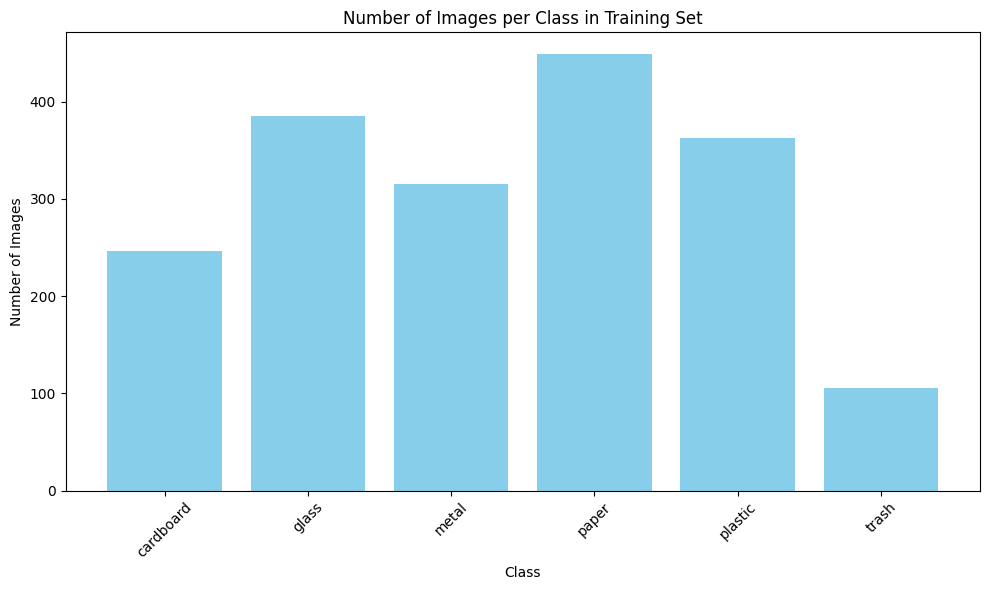

In [16]:
class_counts = {}
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
img_size = []
corrupted_files = []

for folder in os.listdir(data_dir):
    folder_path = glob.glob(os.path.join(data_dir, folder, '*'))
    for img_path in folder_path:
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                width, height = img.size
                channels = len(img.getbands())
                img_size.append((height, width, channels))
        except (UnidentifiedImageError, OSError) as e:
            print(f"Corrupted file: {img_path} -> {e}")
            corrupted_files.append(img_path)

print(f"corrupted images: {len(corrupted_files)}")

# remove corrupted images
for f in corrupted_files:
    os.remove(f)

# Count image sizes for valid images
size_counts = pd.Series(img_size).value_counts()
print(size_counts)


corrupted images: 0
(384, 512, 3)    1865
Name: count, dtype: int64


# Split Data

In [18]:
output_dir = "split_data"            # Where split dataset will be stored

train_ratio = 0.8
test_ratio = 0.2


In [19]:
for split in ["train", "test"]:
    for folder in os.listdir(data_dir):
        os.makedirs(os.path.join(output_dir, split, folder), exist_ok=True)

for folder in os.listdir(data_dir):
    img_paths = glob.glob(os.path.join(data_dir, folder, "*"))
    random.shuffle(img_paths)
    n = len(img_paths)
    n_train = int(n * train_ratio)

    for i, img_path in enumerate(img_paths):
        if i < n_train:
            dest = os.path.join(output_dir, "train", folder)
        else:
            dest = os.path.join(output_dir, "test", folder)
        shutil.copy(img_path, dest)


In [20]:
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

In [21]:
train_gen= tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_gen= tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [22]:
TARGET_COUNT = 500
IMG_SIZE = (256,256)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    images = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.png', '.jpeg'))
    ]

    original_count = len(images)
    print(f"{class_name}: {original_count} original images")

    if original_count >= TARGET_COUNT:
        continue

    # 🔹 Load originals into memory (once)
    x_data = []
    for img_name in images:
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(class_path, img_name),
            target_size=IMG_SIZE
        )
        x_data.append(tf.keras.preprocessing.image.img_to_array(img))

    x_data = np.array(x_data)

    aug_generator = train_gen.flow(
        x_data,
        batch_size=1,
        shuffle=True
    )

    current_count = original_count
    aug_index = 0

    while current_count < TARGET_COUNT:
        batch = next(aug_generator)

        for img in batch:
            if current_count >= TARGET_COUNT:
                break

            img = np.clip(img, 0, 255)

            if img.max() <= 1.0:
                img = img * 255

            img = img.astype(np.uint8)

            save_path = os.path.join(
                class_path,
                f"aug_{aug_index}.jpg"
            )

            tf.keras.preprocessing.image.save_img(save_path, img)

            aug_index += 1
            current_count += 1

    print(f"✅ {class_name} augmented to {current_count} images\n")


cardboard: 197 original images
✅ cardboard augmented to 500 images

glass: 308 original images
✅ glass augmented to 500 images

metal: 252 original images
✅ metal augmented to 500 images

paper: 359 original images
✅ paper augmented to 500 images

plastic: 290 original images
✅ plastic augmented to 500 images

trash: 84 original images
✅ trash augmented to 500 images



In [23]:
train=test_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    classes=class_names,
    batch_size=32,
    shuffle=False   # IMPORTANT
)
test = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    classes=class_names,
    batch_size=32,
    shuffle=False   # IMPORTANT
)

Found 3000 images belonging to 6 classes.
Found 375 images belonging to 6 classes.


In [24]:
print(train.class_indices)
print(test.class_indices)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [25]:
class_labels = {v: k for k, v in train.class_indices.items()}  # Reverse the  dictionary
class_labels

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

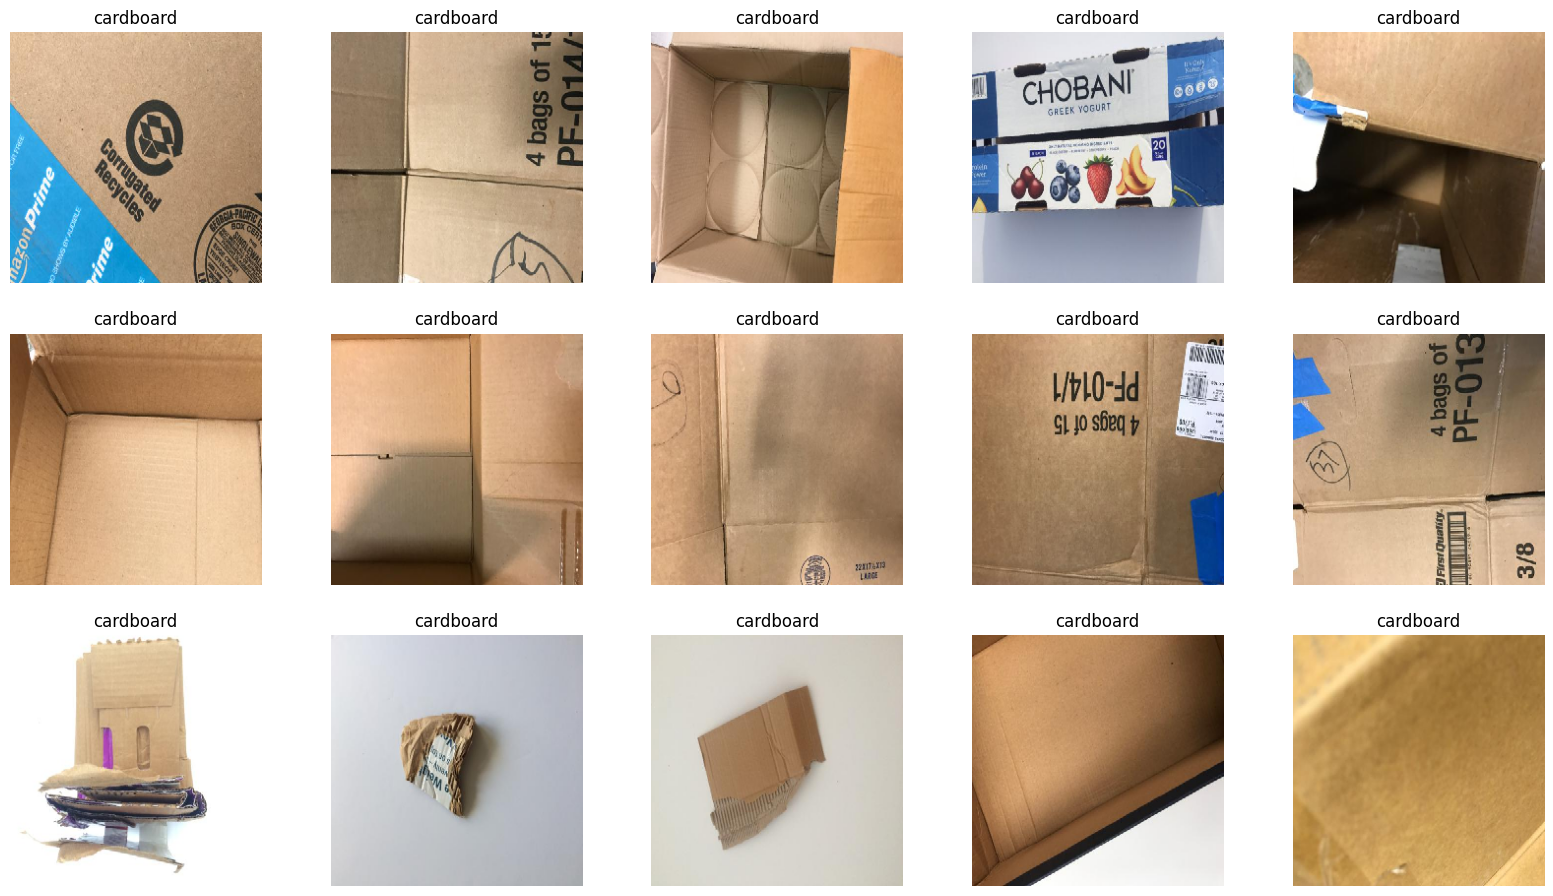

In [26]:
plt.figure(figsize=(20 ,15))
for image_batch, labels_batch in train:
    image = image_batch[1]
    for i in range(1, 16):
        plt.subplot(4, 5, i)
        plt.imshow(image_batch[i])
        label = class_labels[np.argmax(labels_batch[i])]
        plt.title(label)
        plt.axis("off")
    break
    plt.show()

## augmentation impact

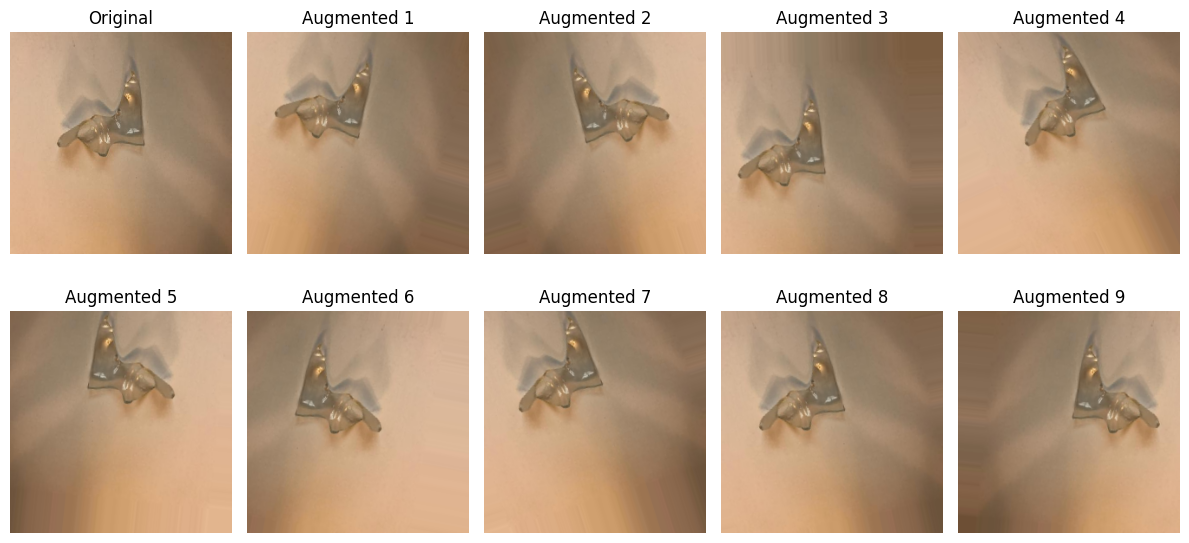

In [27]:
class_folder = os.listdir(train_dir)[1]
image_name = os.listdir(os.path.join(train_dir, class_folder))[1]  # First image in that class
img_path = os.path.join(train_dir, class_folder, image_name)

original_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(original_img)
img_array = np.expand_dims(img_array, axis=0)

augmented_generator = train_gen.flow(
    img_array,
    batch_size=1
)

plt.figure(figsize=(12, 6))

plt.subplot(2, 5, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis('off')

for i in range(9):
    aug_img = next(augmented_generator)[0]
    plt.subplot(2, 5, i + 2)
    plt.imshow(aug_img)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
import tensorflow as tf

base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

feature_extractor = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=x
)

# 🔒 Freeze the CNN
feature_extractor.trainable = False

# Prepare Data For Model

In [30]:
import tensorflow as tf
import numpy as np

def extract_features(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet50.preprocess_input(img)

    features = feature_extractor.predict(img, verbose=0)
    return features.flatten()

In [31]:
from sklearn.preprocessing import LabelEncoder

def load_features_from_dir(base_dir):
    X, y = [], []
    label_encoder = LabelEncoder()

    class_names = sorted(os.listdir(base_dir))
    label_encoder.fit(class_names)

    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            features = extract_features(img_path)
            X.append(features)
            y.append(class_name)

    y = label_encoder.transform(y)
    return np.array(X), np.array(y), label_encoder

In [33]:
x_train, y_train , le = load_features_from_dir(train_dir)
x_test, y_test , _ = load_features_from_dir(test_dir)

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,
    metric="euclidean",
)

knn.fit(x_train, y_train)
print("KNN Accuracy:", knn.score(x_test, y_test))

KNN Accuracy: 0.8506666666666667


In [ ]:
from sklearn.svm import SVC

svm = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
)

svm.fit(x_train, y_train)
print("SVM Accuracy:", svm.score(x_test, y_test))


In [42]:
import joblib
joblib.dump(knn, "models/knn_model.pkl")
joblib.dump(svm, "models/svm_model.pkl")
joblib.dump(le, "models/label_model.pkl")

['models/label_model.pkl']